In [500]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import re
import folium

import gensim
from gensim import corpora
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
# import jellyfish
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import lightgbm
from sklearn import tree



In [501]:
df = pd.read_parquet('_df_for_modeling.parquet')
def data_cleanup(df):

    df.dropna(how='all', axis=1, inplace=True) #drop empty cols

    number_looking_strings = ['id', 'scrape_id', 'host_id']
    for col in number_looking_strings:
        df[col] = df[col].astype("string")

    df['host_response_rate'] = df['host_response_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string

    date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format=r'%Y-%m-%d')

    for col in df.columns:
        if df[col][0] == "f" or df[col][0] == "t": #if first record is "t" or "f" we're going to convert to bool - still should spot check after just incase first record of bool is null
            df[col] = df[col].str.replace("f", "0")
            df[col] = df[col].str.replace("t", "1")
            try: ## int can't hold nulls so if the conversion fails due to a value error, convert to float instead
                df[col] = df[col].astype(int)
            except:
                df[col] = df[col].astype(float)


    remaining_string_cols = df.select_dtypes(include=["object"]).columns #all remaining object columns are strings so I'm explicitly setting them to be
    for col in remaining_string_cols:
        df[col] = df[col].astype('string')

    list_string_cols = ['host_verifications', 'amenities'] #these 2 columns are string lists so I'm converting them back to object just so I remember to handle them differently
    for col in list_string_cols:
        df[col] = df[col].astype('object')

    return df

df = data_cleanup(df)

C:\Users\Immig\AppData\Local\Temp\ipykernel_34256\2129636235.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string


In [502]:
# df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
# df['amenities'] = df['amenities'].apply(lambda x: ' '.join(x))
# df['amenities'] = df['amenities'].apply(lambda x: x.lower())

# # no stemming, but remove stop words and special characters
# df['amenities'] = df['amenities'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# df['amenities'] = df['amenities'].apply(lambda x:" ".join(re.findall(r'[\w]+',x)))


# corpus = [lst.split() for lst in df['amenities']]
# dictionary = corpora.Dictionary(corpus)
# DFM = [dictionary.doc2bow(word_lst) for word_lst in corpus]


# n_topics = 3
# ldamodel = gensim.models.LdaMulticore(DFM,
#                                     num_topics = n_topics,
#                                     id2word = dictionary,
#                                     passes = 20,
#                                     workers=8)

# lda_topic_assignment = [max(x,key=lambda item: item[1]) for x in ldamodel[DFM]]


# vis = pyLDAvis.gensim_models.prepare(ldamodel,
#                                      DFM,
#                                      dictionary)


# # add as a new feature to the df
# df['amenity_topic'] = [val[0] for val in lda_topic_assignment]
# df['amenity_topic'] = df['amenity_topic'].astype('string')
# df.drop(columns=['amenities'], inplace=True)

# vis

In [503]:
#drop columns with primarily unique values - this will take care of things like ids, urls, descriptions, etc
drop_list = []
string_cols = df.select_dtypes(include=["object","string"]).columns
for col in string_cols:
    if len(df[col].value_counts()) > 1000:
        drop_list.append(col)

print(drop_list, "getting dropped.")
df.drop(columns=drop_list, inplace=True)


#also drop neighborhood because there's a cleansed column with this
df.drop(columns=['neighbourhood'], inplace=True)

#also drop price as the feature 'avg_price' replaces it
df.drop(columns=['price'], inplace=True)

['id', 'listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'amenities'] getting dropped.


In [504]:
df['host_tenure'] = (df['last_scraped']-df['host_since']).dt.days

# some listings have no value for host_since leading to a null for host_tenure. Replace these with 0
df['host_tenure'] = df['host_tenure'].fillna(0).astype(int)

# Change host_location to be a binary, nashville or not nashville
df['host_location'] = df['host_location'].fillna(' ').apply(lambda x: 1 if "nashville" in x.lower() else 0) # host location is now a binary (1 if host is in Nashville, else 0)

In [506]:
#drop dep_candidate and all variables similar to what was used to create it
drop_cols = []
for col in df.columns:
    if "review" in col:
        drop_cols.append(col)
    if "availability" in col:
        drop_cols.append(col)
    if "host" in col:
        drop_cols.append(col)
drop_cols.append("scrape_id")
drop_cols.append("last_scraped")
drop_cols.append("host_since")
drop_cols.append("calendar_last_scraped")
print(drop_cols, "getting dropped")
df.drop(columns=drop_cols, inplace=True)

['host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_tenure']


In [507]:
# df.drop(columns=['host_neighbourhood'], inplace=True)
# df.drop(columns=['host_verifications'], inplace=True)
df.drop(columns=['property_type'], inplace=True)

In [508]:
df.select_dtypes(include=["object","string"]).describe(include='all')

neighbourhood_cleansed        room_type bathrooms_text
count                    6863             6863           6861
unique                     35                4             32
top               District 19  Entire home/apt         1 bath
freq                     1716             6256           2472

In [509]:
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace('District ', '')
df.rename(columns={'neighbourhood_cleansed':'district'},inplace=True)

In [510]:
df['bathrooms_text'].value_counts()

def clean_bathrooms(x):
    words = x.split()
    values= []
    for word in words:
        try:
            values.append(float(word))
        except:
            values.append(0)
    
    if x == "Half-bath":
        val = "1"
    elif max(values) == 0:
        val = "0"
    elif max(values) == 1:
        val = "1"
    elif max(values) <= 3:
        val = "2-3"
    else:
        val = ">3"
    
    if "shared" in x:
        val = "shared"
    
    return val

df['bathrooms_text'] = df['bathrooms_text'].fillna("-1").apply(clean_bathrooms)
df.rename(columns={'bathrooms_text':'baths'},inplace=True)


In [511]:
#dep_var_cutoff = df['dep_candidate'].mean()
dep_var_cutoff = df['dep_candidate'].quantile(.90)
df['dep_candidate_cutoff_bool'] = (df['dep_candidate'] >= dep_var_cutoff).astype(int)
df.drop(columns=['dep_candidate'], inplace=True)

In [512]:
listings_1 = df[df["dep_candidate_cutoff_bool"]==1][["latitude", "longitude"]]
listings_0 = df[df["dep_candidate_cutoff_bool"]==0][["latitude", "longitude"]]

map = folium.Map(location=[df['latitude'].quantile(0.5), 
                        df['longitude'].quantile(0.5)],
                        zoom_start=11, 
                        control_scale=True,
                        tiles="cartodbpositron",
                        width=800, height=600)

for index, rowdata in listings_0.iterrows():
    folium.CircleMarker([rowdata["latitude"], rowdata["longitude"]],
                        radius=1, fill=False,
                        color = '#ff0f0f75').add_to(map) #red
for index, rowdata in listings_1.iterrows():
    folium.CircleMarker([rowdata["latitude"], rowdata["longitude"]],
                        radius=1, fill=False,
                        color = '#0aab2275').add_to(map) # green

map

In [450]:
# Separate target variable and feature columns
target = df["dep_candidate_cutoff_bool"]
features = df.drop(["dep_candidate_cutoff_bool"], axis=1)

# Impute missing values using mode for categorical columns and median for numerical columns
cat_columns = features.select_dtypes(include=["string","object"]).columns
num_columns = features.select_dtypes(include="number").columns

# Replace missing values in the categorical columns with the most frequent value
for col in cat_columns:
        features[col].fillna("⍼", inplace=True)

# Replace missing values in the numerical columns with the median value
for col in num_columns:
    features[col].fillna(features[col].mean(), inplace=True)

features = pd.get_dummies(features, drop_first=True)

In [451]:
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6863 entries, 0 to 6862
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   latitude                6863 non-null   float64
 1   longitude               6863 non-null   float64
 2   accommodates            6863 non-null   int64  
 3   bedrooms                6863 non-null   float64
 4   beds                    6863 non-null   float64
 5   minimum_nights          6863 non-null   int64  
 6   maximum_nights          6863 non-null   int64  
 7   minimum_minimum_nights  6863 non-null   float64
 8   maximum_minimum_nights  6863 non-null   float64
 9   minimum_maximum_nights  6863 non-null   float64
 10  maximum_maximum_nights  6863 non-null   float64
 11  minimum_nights_avg_ntm  6863 non-null   float64
 12  maximum_nights_avg_ntm  6863 non-null   float64
 13  instant_bookable        6863 non-null   int32  
 14  avg_price               6863 non-null   

In [452]:
features.columns

Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'instant_bookable', 'avg_price',
       'district_10', 'district_11', 'district_12', 'district_13',
       'district_14', 'district_15', 'district_16', 'district_17',
       'district_18', 'district_19', 'district_2', 'district_20',
       'district_21', 'district_22', 'district_23', 'district_24',
       'district_25', 'district_26', 'district_27', 'district_28',
       'district_29', 'district_3', 'district_30', 'district_31',
       'district_32', 'district_33', 'district_34', 'district_35',
       'district_4', 'district_5', 'district_6', 'district_7', 'district_8',
       'district_9', 'room_type_Hotelroom', 'room_type_Privateroom',
       'room_type_Sharedroom', 'baths_1', 'baths_23', 'baths_3',
 

In [453]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [454]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 999)
# Define tree model and model parameters to evalaute
params = {'criterion': ['entropy', 'gini'], 'max_depth': list(np.arange(1,15,1)), 'min_samples_split': list(np.arange(2,31,2))}
model_dtree = tree.DecisionTreeClassifier()

gscv_dtree = GridSearchCV(estimator=model_dtree, param_grid=params, verbose=1, cv=cv, n_jobs=-1, scoring='roc_auc', refit=True).fit(X_train, y_train)

# y_pred_dtree = gscv_dtree.predict_proba(X_test)
# print('roc_auc:', roc_auc_score(y_test, y_pred_dtree[:,1]))

print(gscv_dtree.best_params_)
print('Decision tree AUC-score:', gscv_dtree.score(X_test, y_test))
print(' ')



# Train a LightGBM model on the training data
model_lgbm = lightgbm.LGBMClassifier()
params = {'max_bin': [128, 255, 512], 'max_depth': list(np.arange(1,15,1)), 'min_data_in_leaf': list(np.arange(2,51,3))}
gscv_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=params, verbose=1, cv=cv, n_jobs=-1, scoring='roc_auc', refit=True).fit(X_train, y_train)


# Evaluate the performance of the model
# print(classification_report(y_test, y_pred, digits=5))
print(gscv_lgbm.best_params_)
print('LGBM AUC-score:', gscv_lgbm.score(X_test, y_test))

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
Decision tree AUC-score: 0.791206546056328
 
Fitting 5 folds for each of 714 candidates, totalling 3570 fits
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
{'max_bin': 512, 'max_depth': 5, 'min_data_in_leaf': 29}
LGBM AUC-score: 0.8306968975697459


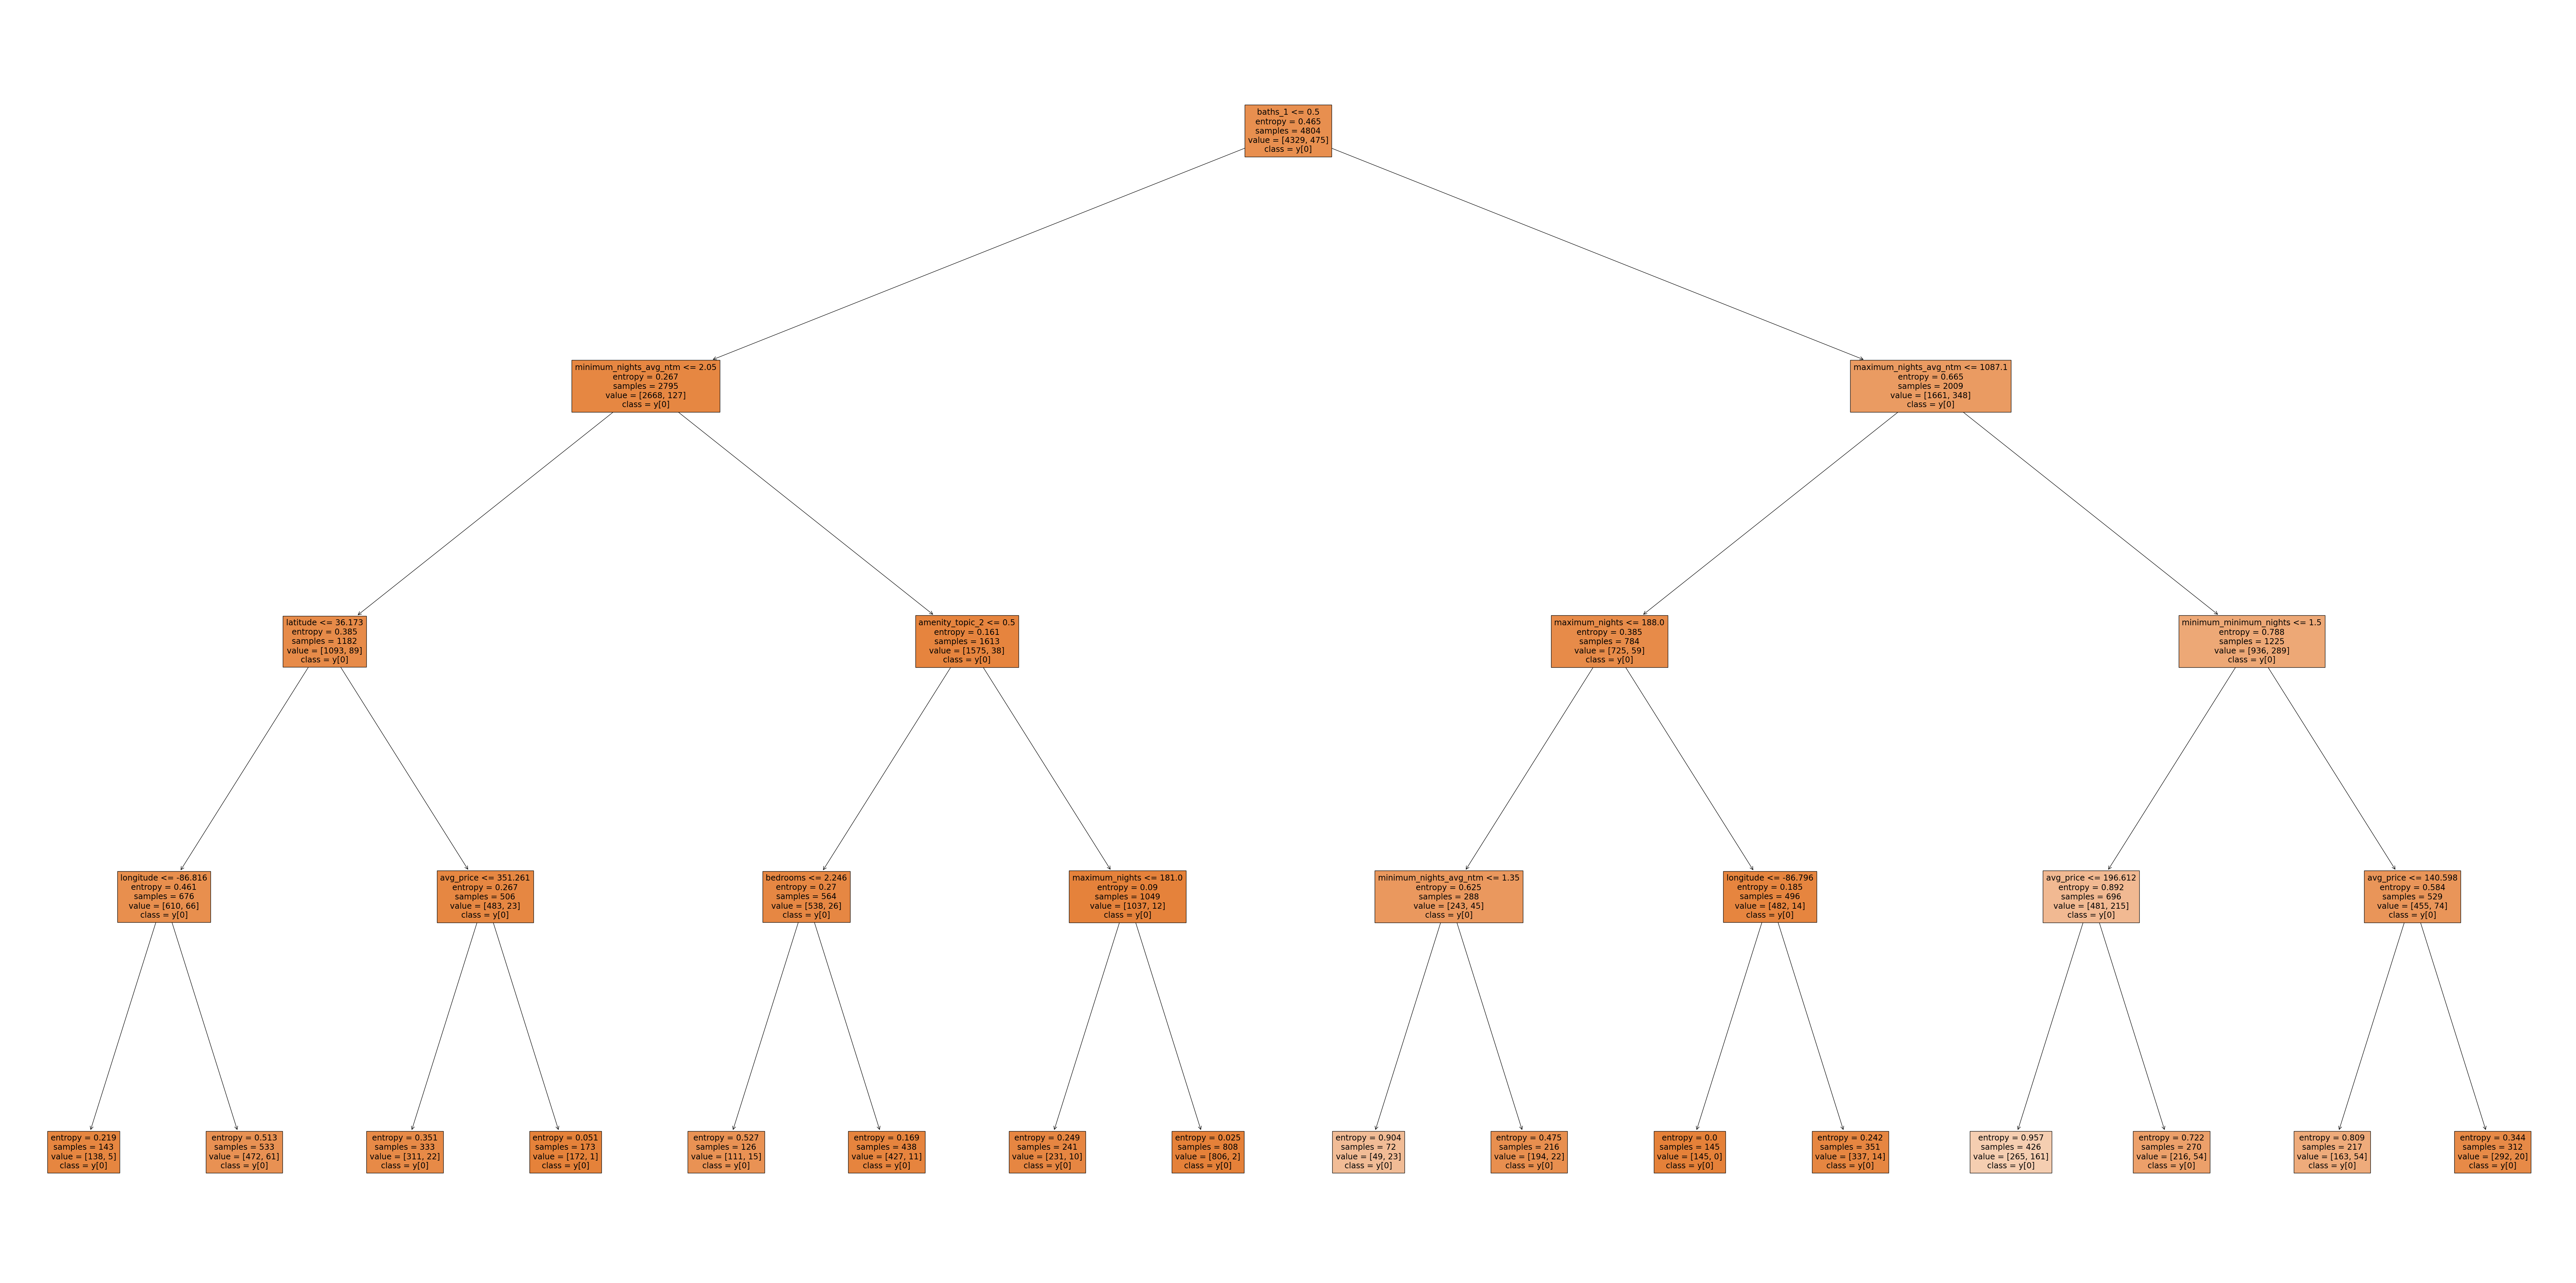

In [455]:
plt.figure(figsize=[100,50])
# plt.figure(dpi=150)
tree.plot_tree(gscv_dtree.best_estimator_,
               proportion=False,
               feature_names=list(features.columns.values),
               class_names=True,
               filled=True)
plt.show()

In [456]:
# Train a LightGBM model on the training data
model_lgbm = lightgbm.LGBMClassifier(max_bin = gscv_lgbm.best_params_['max_bin'],
                                     max_depth = gscv_lgbm.best_params_['max_depth'], 
                                     min_data_in_leaf = gscv_lgbm.best_params_['min_data_in_leaf'])
model_lgbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgbm = model_lgbm.predict_proba(X_test)

# Evaluate the performance of the model
# print(classification_report(y_test, y_pred, digits=5))
print('roc_auc:', roc_auc_score(y_test, y_pred_lgbm[:,1]))

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
roc_auc: 0.8306968975697459


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

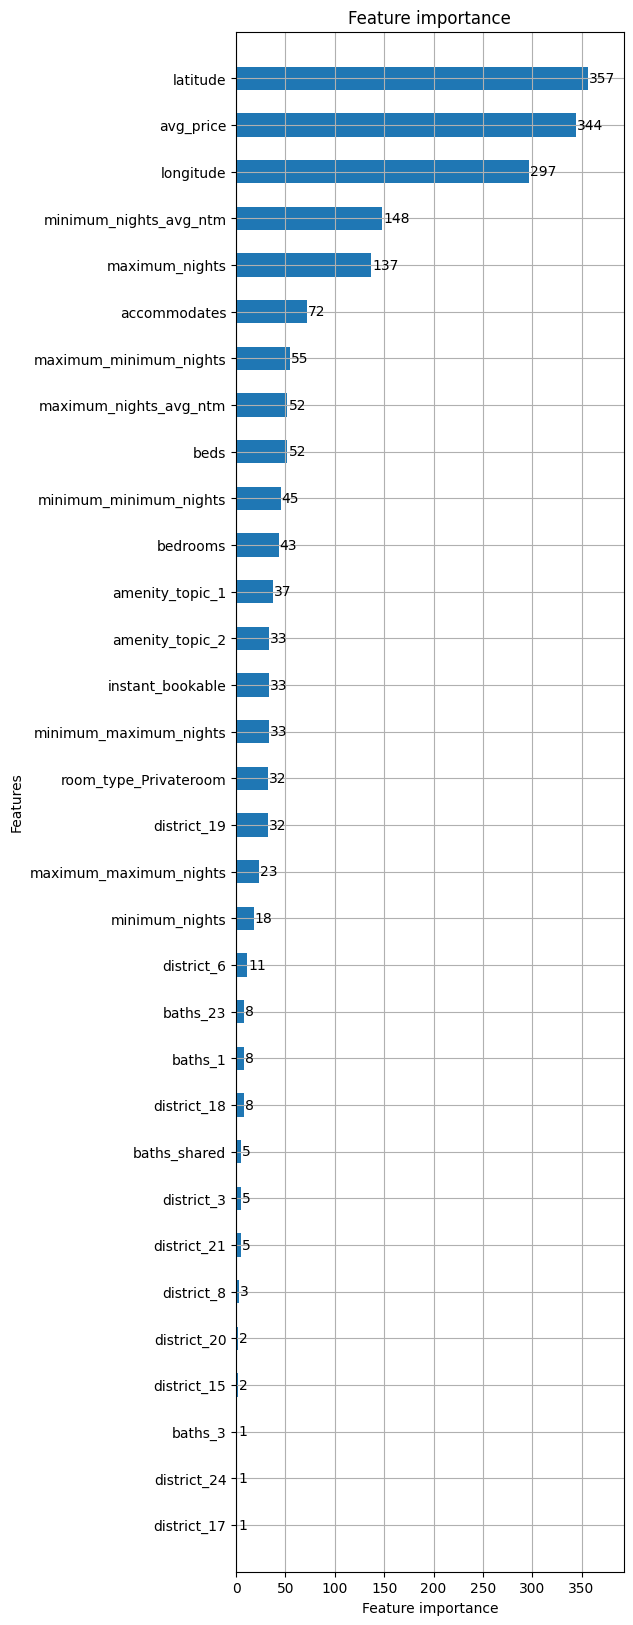

In [457]:
plt.rcParams['figure.figsize'] = (5,20)
lightgbm.plot_importance(model_lgbm, height=0.5)